## Linear Regression - pickling (Serialization and Persistance)
#### What is Pickling ? 
#### An application of training persistence to avoid frequent learning process  
### Stock Price forcasting (WIKI/GOOGL dataset)

In [2]:
import pandas as pd 
import numpy as np
import math
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 14

### Importing  dataset 

In [3]:
# Importing dataset 
# Here the dataset is a StockPrice TimeSeries for price forecasting  
data = pd.read_csv('dataset/dataset-stock-prices-google.csv')
# Set column "Date" as index (Important fo TimeSeries dataset)
data = data.set_index('Date')
#print(data.head())
#print(data.columns.get_loc("Adj. Open"))

## Preprocessing data 

In [4]:
# Select fews features only
# The relationship between features is valuable(Ex. High-Low difference tells the volatility of the day) 
data = data[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
# Create new features 
#   --> Rate of the volatility in percent
data['High-Low Percent diff'] = (data['Adj. High'] - data['Adj. Low']) / data['Adj. Close'] * 100.0
data['Daily Percent change'] = (data['Adj. Close'] - data['Adj. Open']) / data['Adj. Open'] * 100.0
data = data[['Adj. Close', 'High-Low Percent diff', 'Daily Percent change', 'Adj. Volume']]

# Define the label(dependent variable)
# Make "Adjusted Close" as label 
y_forecast_col = 'Adj. Close'

# Fill NaN
data.fillna(-99999, inplace=True)

# Get number of testing data (8% of the dataset) 
no_test_data = int(math.ceil(0.01*len(data)))
#print(data[y_forecast_col].head())


# Append "label" col to the dataset 
# Shift "label" from Down-to-Top so that we get the latest data
# Means, these labels would be the X label of data[:-no_text_data]
#        shifting the entire data results 100% of accuracy, 
#        so shifting the label makes noise to the model 
data['label'] = data[y_forecast_col].shift(periods = -no_test_data)

# Define X Training [0:-no_test_data]
X = np.array(data.drop(['label'], axis=1))
X = preprocessing.scale(X)
X = X[:-no_test_data]

# Define X to forecast [-no_test_data:]
X_forecast = X[-no_test_data:] 

# Define Y 
data.dropna(inplace=True)
y = np.array(data['label'])

### Training 

In [14]:
from sklearn import  svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle 

# Split Training set and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train linear Regression model
# {n_jobs = -1} running no. of jobs as many as possible in parallel   
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, y_train)

# Pickle(dump) the model into a file "stock-price-model.pickle"
with open('stock-price-model.pickle', 'wb') as file: 
    pickle.dump(lr_model, file)
model_in = open('stock-price-model.pickle', 'rb')
lr_model = pickle.load(model_in)

acc_lr = lr_model.score(X_test, y_test)
print('Testing accuracy: {:.3f}%'.format(acc_lr*100))

Testing accuracy: 97.667%


### Forecasting 

In [6]:
y_forecast = lr_model.predict(X_forecast)

### Plot forecasting 

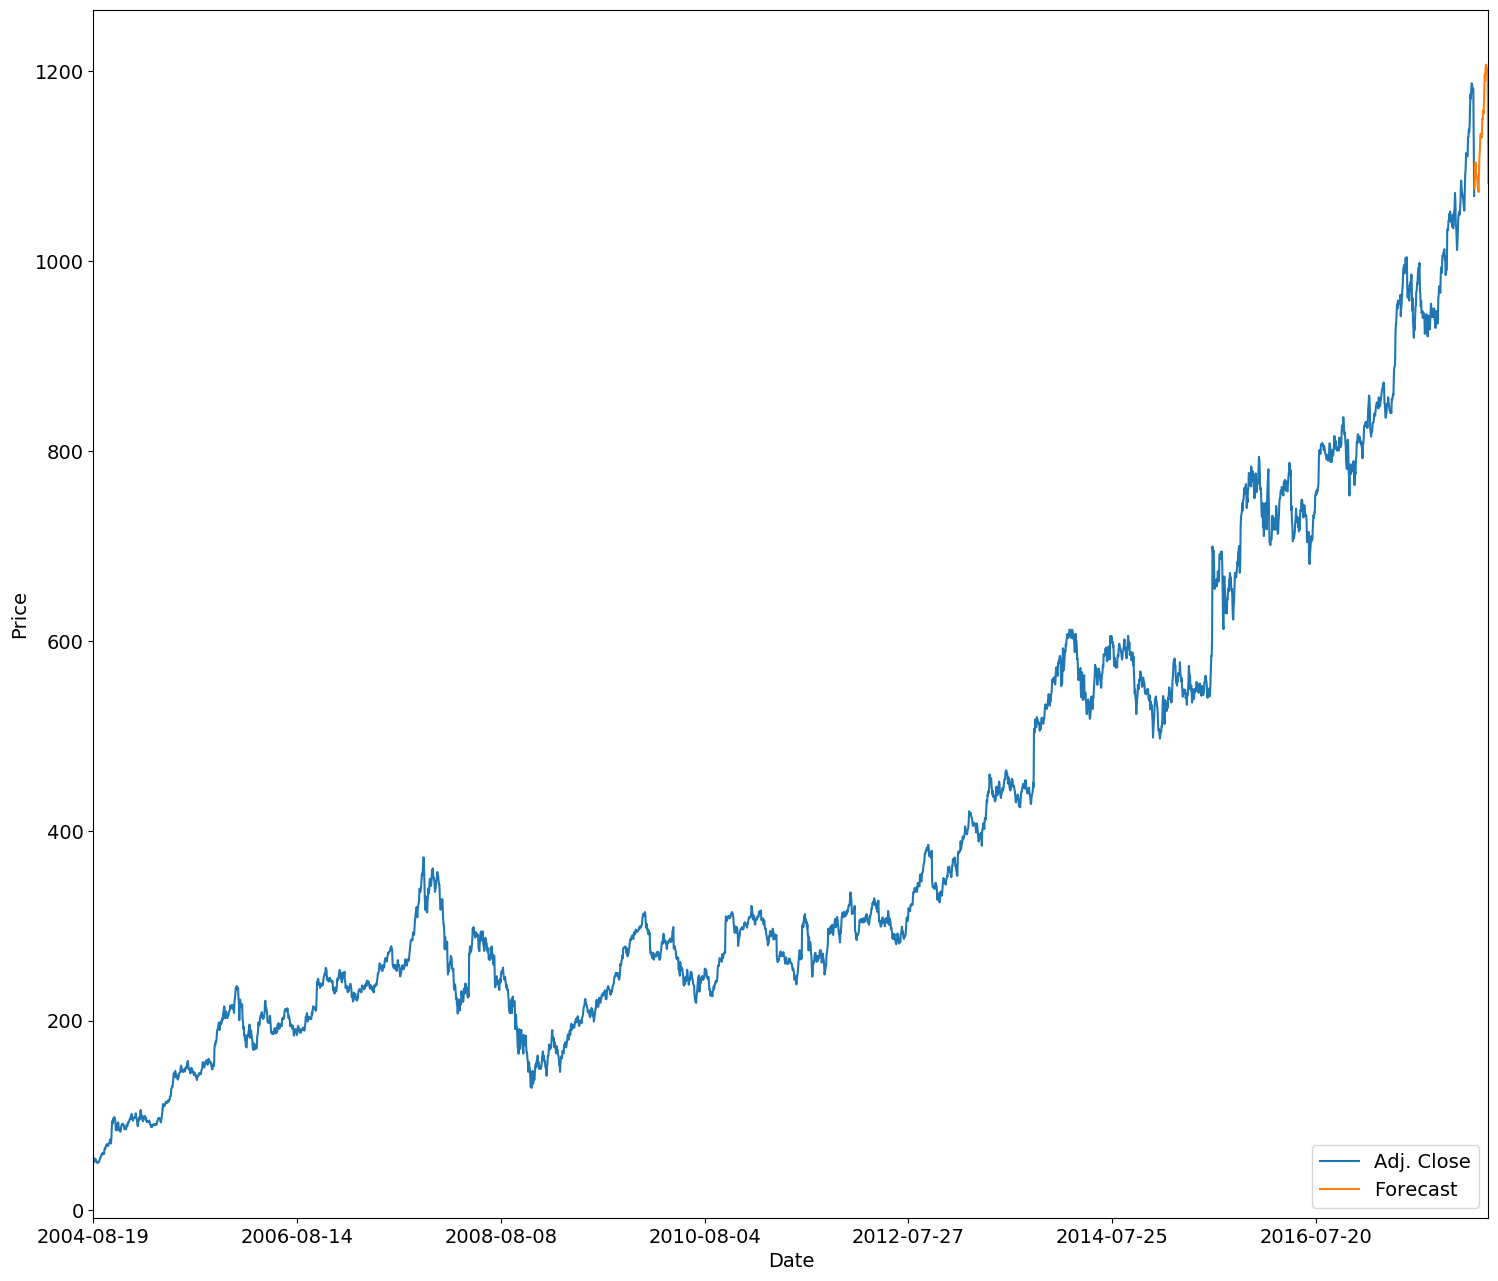

In [7]:
import math, datetime
import matplotlib.pyplot as plt 
#from matplotlib import style 
#style.use('ggplot')

# Plot forecasting upon the date from the last date appearing in the column 'Date' of the original dataset 
last_day = data.iloc[-1].name
last_day_unix_format = datetime.datetime.strptime(last_day, "%Y-%m-%d")
last_day_timestamp = last_day_unix_format.timestamp()
one_day = 86400
next_day = last_day_timestamp + one_day*2

# Create new column "Forecast" to store y_forecast  
data['Forecast'] = np.nan 

for forecast in y_forecast:
    # next_date: %Y-%m-%d
    next_date = datetime.datetime.utcfromtimestamp(next_day).strftime('%Y-%m-%d')
    next_day += one_day
    
    # Append y_forecast to the last column of the original dataset 
    data.loc[next_date] = [np.nan for _ in range( len(data.columns)-1 )] + [forecast]
    

data['Adj. Close'].plot()
data['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Testing data to different learning models

In [9]:
# Create another model(SVM) with different Kernels 
#   - SVR(Support Vector Regression) 
# Train with different params
svr_model_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=0.1, coef0=1)
svr_model_lin = svm.SVR(kernel='linear', C=100, gamma='auto')
svr_model_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
# Training using #ts kernels 
svr_model_poly.fit(X_train, y_train)
svr_model_lin.fit(X_train, y_train)
svr_model_rbf.fit(X_train, y_train)
# Testing 
acc_poly = svr_model_poly.score(X_test, y_test)
acc_lin = svr_model_lin.score(X_test, y_test)
acc_rbf = svr_model_rbf.score(X_test, y_test)

print('Accuracy score upon the kernel:')
print('POLY: {:.4f}%'.format(acc_poly*100))
print('LINEAR: {:.4f}%'.format(acc_lin*100))
print('RBF: {:.4f}%'.format(acc_rbf*100))


Accuracy score upon the kernel:
POLY: 97.8422%
LINEAR: 97.7646%
RBF: 97.6821%


,Adj. Close,High-Low Percent diff,Daily Percent change,Adj. Volume,label,Forecast
Date,,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,69.078238,NaN
2004-08-20,54.322689,7.921706,7.227007,22834300.0,67.839414,NaN
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,68.912727,NaN
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,70.668146,NaN
2004-08-25,53.164113,3.886792,1.183658,9188600.0,71.219849,NaN
2004-08-26,54.122070,3.048837,2.820391,7094800.0,72.278116,NaN
2004-08-27,53.239345,2.760245,-1.803885,6211700.0,74.810934,NaN
2004-08-30,51.162935,3.411430,-3.106003,5196700.0,74.199045,NaN
2004-08-31,51.343492,1.514115,0.048866,4917800.0,70.462511,NaN
